In [1]:
%run Latex_macros.ipynb

<IPython.core.display.Latex object>

In [2]:
# My standard magic !  You will see this in almost all my notebooks.

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%load_ext autoreload
%autoreload 1

%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import neural_net_helper
%aimport neural_net_helper

nnh = neural_net_helper.NN_Helper()

In [4]:
from scipy import stats

def RELU_variant_input():
    return np.arange(-5,5, 0.1) 

def plot_RELU_variant(variant_out, name, label, ax):
    layer_out = RELU_variant_input()

    _= ax.plot(layer_out, variant_out )
    _= ax.set_xlabel("Input", size=14)
    _= ax.set_ylabel(label, size=14)
    _= ax.set_title(name, size=20)

    return fig, ax

def plot_RELU_variants():
    variant_input = RELU_variant_input() 

    fig, axs = plt.subplots( 1, 3, figsize=(12,4))

    # ReLU
    _= plot_RELU_variant( variant_input * (variant_input >= 0) + 0 * (variant_input < 0),
                          "ReLU",
                          f"Output",
                          axs[0]
                         )

    # Leaky ReLU
    leakage_rate = 0.05
    _= plot_RELU_variant( variant_input * (variant_input >= 0) + variant_input * leakage_rate * (variant_input < 0),
                          "Leaky ReLU",
                          f"Output: leakage {leakage_rate}",
                          axs[1]
                         )

    # GELU
    _= plot_RELU_variant( variant_input * stats.norm.cdf(variant_input),
                          "GELU",
                          f"Output",
                          axs[2]
                         )

    fig.tight_layout()

# Vanishing/exploding gradients

Now that we have a better view of how backward propagation of gradients work, we are equipped
to understand the difficulties of training the weights.

Until the problems were understood, and solutions found, the evolution of Deep Learning
was extremely slow.

Let's summarize back propagation up until this point
- We compute the loss gradient $\loss'_\llp = \frac{\partial \loss}{\partial \y_\llp}$ of each layer $\ll$ in descending order

- The backward step  to compute the loss gradient of the preceding layer is:  
    - $\loss'_{(\ll-1)} =  \loss'_\llp \frac{\partial \y_\llp}{\partial \y_{(\ll-1)}}$

When we derived back propagation, we didn't look "inside" of the "local gradient " $\frac{\partial \y_\llp}{\partial \y_{(\ll-1)}}$

We will do so now.

Let's look more deeply into the  term $\frac{\partial \y_\llp}{\partial \y_{(i-1)}}$

$$
\begin{array}[lllll] \\
\frac{\partial \y_\llp}{\partial \y_{(\ll-1)}} & = & \frac{\partial a_\llp ( f_\llp(\y_{(\ll-1)}, \W_\llp))}{\partial \y_{(\ll-1)}} & (\text{def. of } \y_\llp) \\
                                      & = & \frac{\partial a_\llp ( f_\llp(\y_{(\ll-1)}, W_\llp) )}{\partial f_\llp(\y_{(\ll-1)}, \W_\llp)} \frac{\partial f_\llp(\y_{(\ll-1)}, \W_\llp)}{\partial \y_{(\ll-1)}} &  (\text{chain rule}) \\
                                      & = a'_\llp f'_\llp
\end{array}
$$

where we define

$$
\begin{array}[lll] \\
a'_\llp & = & \frac{\partial a_\llp ( f_\llp(\y_{(\ll-1)}, \W_\llp) )}{\partial f_\llp(\y_{(\ll-1)}, \W_\llp)}  & \text{derivative of } a_\llp(\ldots) \text{ wrt } f_\llp(\ldots)\\
f'_\llp & = & \frac{\partial f_\llp(\y_{(\ll-1)}, W_\llp)}{\partial \y_{(\ll-1)}} & \text{derivative of } f_\llp(\ldots) \text{ wrt } \y_{(\ll-1)}\\
\end{array}
$$

$a'_\llp$ is the derivative of activation function $a_\llp$.

We won't explicitly write it out other than to observe $a'_\llp \in [0,1]$.


Substituting the value of the loss gradient into the backward update rule:

$$
\begin{array}[llll]\\
\loss'_{(\ll-1)} & = &  \loss'_\llp \frac{\partial \y_\llp}{\partial \y_{(\ll-1)}} \\
         & = &  \loss'_\llp a'_\llp f'_\llp
\end{array}
$$

Hopefully, you can see that if iterate through single backward steps, we can derive
an expression for the loss gradient at layer $\ll$ in terms of the loss gradient
of the final layer $K$:

Since
$$\loss'_\llp  =   \loss'_{(\ll+1)} \frac{\partial \y_{(\ll+1)}}{\partial \y_\llp}$$

we get
$$\loss'_\llp  =   \loss'_{(L+1)} \prod_{l'=\ll+1}^L  a'_{(l')} f'_{(l')}$$

The issue is that, since 
$$
0 \le a'_\llp \le \max{z} a'_\llp(z)
$$

the product 
$$\prod_{l'=i+1}^K {a'_{(l')}}
$$
can be increasingly small as the number of layers $K$ grows, if $\max{z} a'_\llp(z) < 1$.

A plot of activation functions and their derivatives follows.

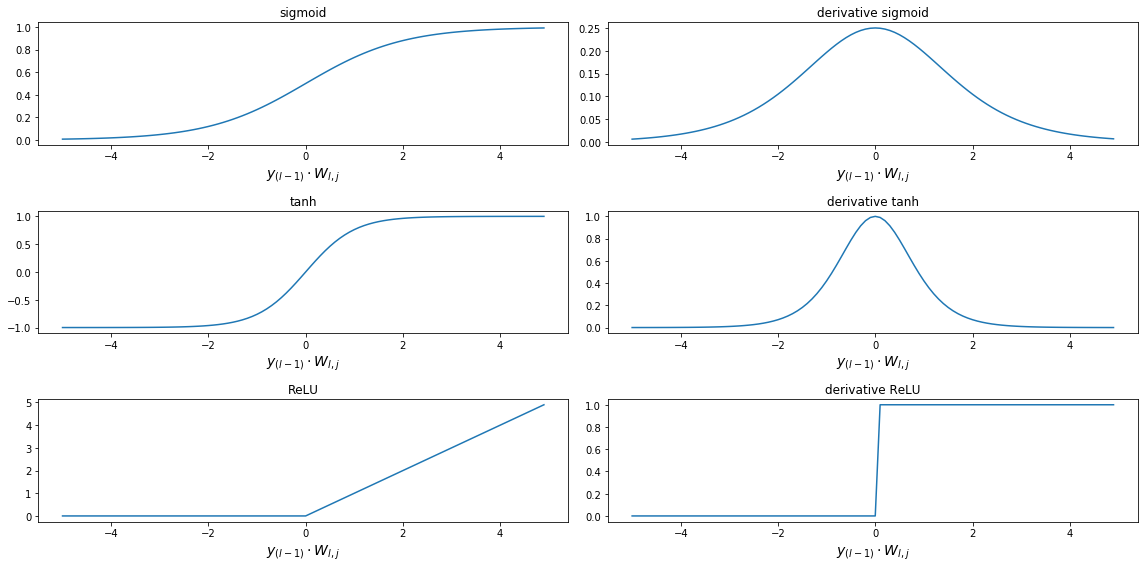

In [5]:
fig, _ = nnh.plot_activations( np.arange(-5,5, 0.1) )

Thus, unless offset by the $f'_\llp$ terms, $\loss'_\llp$ will quickly diminish to $0$ as $K$ decreases,
i.e., as we seek to compute $\loss'_\llp$ for layers $\ll$ closest to the input.

This means 

$$
\begin{array}[lll] \\
\frac{\partial \loss}{\partial W_\llp} & = & \frac{\partial \loss}{\partial y_\llp} \frac{\partial y_\llp}{\partial W_\llp} & = & \loss'_\llp \frac{\partial y_\llp}{\partial W_\ip}
\end{array}
$$
will approach $0$.
Since this term is used in the update to $W_\ip$, we won't learn weights for the earliest layers.

Re-visiting our running example
- we compute the (average/variance across units) gradient value
- for each layer in each epoch

Focusing on Sigmoid column of the chart below
- we see that mean gradients are essentially 0 throughout training for non-Classifier layers
    - mean 0, very small standard deviation
- note that the maximum value of the Sigmoid's derivative is $0.25$    
    - so the Sigmoid activation is very exposed to Vanishing gradients



<table>
    <tr>
        <td><center>RELU</center></td> 
        <td><center>SIGMOID</center></td>
        <td><center>TANH</center></td>
    </tr>
    <tr>
        <td colspan="3">
            <img src="images/tnn_gradient.png">
    </tr>
</table>

The gradient behavior across epochs for the networks using ReLU or Tanh are somewhat better
- small mean, but larger variance.  Hence the gradient for many activations is non-zero.
- Observe that the maximum derivative for these activations is around $1$.

We can now diagnose one reason that training of early Deep Learning networks was difficult
- use of sigmoid activations were common (inspired by biology)
- if activations were very large/small, we are in a region where the sigmoid's derivatives are $0$
- even when non-zero,the maximum of the derivative of the sigmoid is much smaller than $1$
- the end result was that deep networks suffered from Vanishing Gradients

## Why the ReLU became the common activation function

One half of the domain of the ReLU has non-zero (and, depending on slope, greater than 1) gradient.
- This makes it less susceptible to the Vanishing gradient problem.

Still: half of the domain of the ReLU has zero gradient, which may impede learning.

There are variants of ReLU
- constructed such that gradient is non-zero everywhere
- hopefully facilitating faster convergence in training

Some examples (and their plots below)
- Leaky ReLU
$$
\text{LeakyReLU}(x) = x * (x \ge 0) + x * \alpha * (x \lt 0)
$$
for small $\alpha$ (leakage) rate
- [Gaussian Error Linear Unit (GELU)](https://arxiv.org/pdf/1606.08415v3.pdf)
$$
\text{GELU}(x) = x * \text{NormCDF}(x)
$$
The belief is that this may facilitate learning.

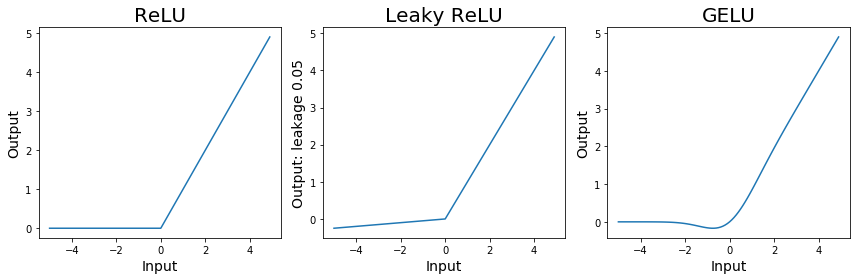

In [6]:
_= plot_RELU_variants()

# Conclusion

Something seemingly as simple as taking derivatives turned out to have some important subtleties.

The problem of gradients either shrinking to zero or growing too large is a real problem
- It can still hinder the use of very deep (many layers) networks
- This is particularly a problem in Recurrent networks
    - The depth of the "unrolled loop" is the length of the input sequence

We will explore techniques to manage the issue of vanishing and exploding gradients.

In [7]:
print("Done")

Done
